## Ristretto-3B

* From LiAutoAD
* Rank #33 in OpenCompass multimodal academic leaderboard for open-source models (https://rank.opencompass.org.cn/leaderboard-multimodal)

In [1]:
import torch
from transformers import AutoModel, AutoTokenizer
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

model_path = '/data/students/earl/llava-dissector/Ristretto-3B'
model = AutoModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map='auto').eval().cuda()
tokenizer = AutoTokenizer.from_pretrained(model_path, 
                                          trust_remote_code=True) 
                                          #use_fast=False)


/data/students/earl/anaconda3/envs/rca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]
Some weights of CustomQwen2ForCausalLM were not initialized from the model checkpoint at /data/students/earl/llava-dissector/Ristretto-3B and are newly initialized: ['embed_tokens.weight', 'layers.0.input_layernorm.weight', 'layers.0.mlp.down_proj.weight', 'layers.0.mlp.gate_proj.weight', 'layers.0.mlp.up_proj.weight', 'layers.0.post_attention_layernorm.weight', 'layers.0.self_attn.k_proj.bias', 'layers.0.self_attn.k_proj.weight', 'layers.0.self_attn.o_proj.weight', 'layers.0.self_attn.q_proj.bias', 'layers.0.self_attn.q_proj.weight', 'layers.0

User: Give the bounding box coordinates in the normalized format [x1, y1, x2, y2] with x1, y1 corresponding to the top left corner and x2,y2 to the bottom right corner enclosed in square brackets for each person in the image, separated by newlines, and nothing else.
Assistant: [0.36, 0.33, 0.54, 0.76]
[0.23, 0.53, 0.42, 0.85]
[0.74, 0.44, 0.81, 0.61]
[0.88, 0.45, 0.92, 0.56]
Bounding Boxes: [[0.36, 0.33, 0.54, 0.76], [0.23, 0.53, 0.42, 0.85], [0.74, 0.44, 0.81, 0.61], [0.88, 0.45, 0.92, 0.56]]


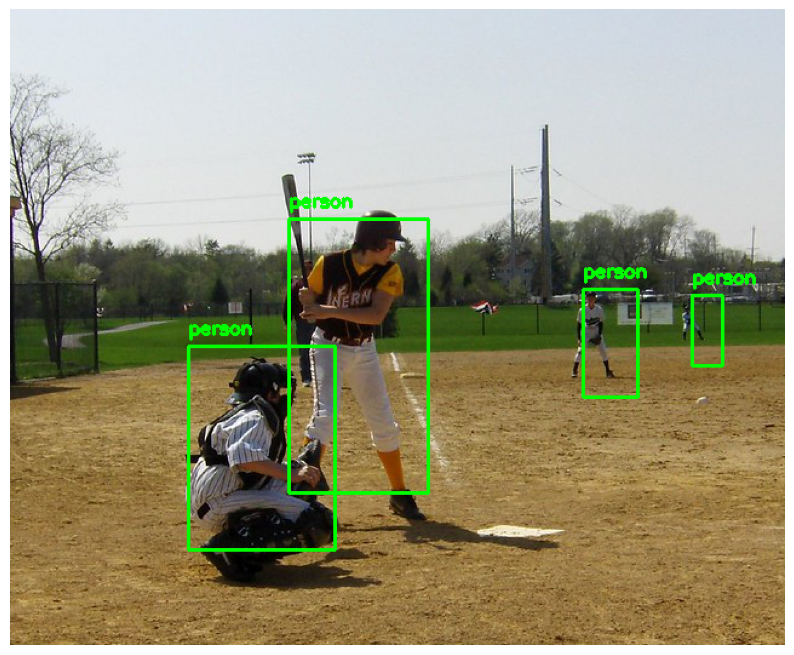

In [3]:
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import GenerationConfig
import requests
from io import BytesIO
import re
import cv2
from matplotlib import pyplot as plt
import numpy as np

cls = "person"
model.threshold = -100


IMAGENET_MEAN = (0.5, 0.5, 0.5)
IMAGENET_STD = (0.5, 0.5, 0.5)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=10, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=384, max_num=10):
    # Check if image_file is a URL
    if isinstance(image_file, str) and (image_file.startswith('http://') or image_file.startswith('https://')):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
pixel_values = load_image(url).to(torch.bfloat16)
# Ensure pixel_values is on the same device as the model
device = next(model.parameters()).device
pixel_values = pixel_values.to(device)

generation_config = dict(max_new_tokens=1024, 
                                     temperature=0.0,
                                     do_sample=False,
                                     top_p=1.0,
                                     top_k=1)

text = f'Give the bounding box coordinates in the normalized format [x1, y1, x2, y2] with x1, y1 corresponding to the top left corner and x2,y2 to the bottom right corner enclosed in square brackets for each {cls} in the image, separated by newlines, and nothing else.'
#question = f'<image></image> {text}.'
question = f'{text}'
msgs = [{"role": "user", "content": question}]
response = model.chat(
    tokenizer,
    pixel_values,
    question,
    generation_config=generation_config
)
print(f'User: {question}\nAssistant: {response}')

# regex the part of string to extract bounding boxes
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)])|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, response)
bounding_boxes = []
for match in matches:
    # Each match is a tuple of 8 elements, only 4 will be filled
    coords = [c for c in match if c != '']
    if len(coords) == 4:
        bounding_boxes.append([float(c) for c in coords])
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
image_from_url = requests.get(url)
orig_img = Image.open(BytesIO(image_from_url.content)).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
